In [1]:
import numpy as np
import csv
import math
import cv2
import pickle
from collections import defaultdict
from datetime import datetime, timedelta
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.segmentation import find_boundaries
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from numpy.linalg import inv
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier

In [2]:
def file_reading(file_path):
    #reading annotations file
    ann_file = open(file_path,"r") #opening file in read mode only
    strings = [x.strip() for x in ann_file.readlines()]
    stimes=[]
    etimes=[]
    for i in range(len(strings)):
        s1,s2=strings[i].split("-")
        stimes.append(s1.strip())
        etimes.append(s2.strip())
    return stimes,etimes

In [3]:
def compare(stime,etime,abnormal_stimes,abnormal_etimes):
    length = len(abnormal_stimes)
    for i in range(length):
        t1 = datetime.strptime(abnormal_stimes[i], '%M:%S').time()
        t2 = datetime.strptime(abnormal_etimes[i], '%M:%S').time()
        obj1 = timedelta(hours=t1.hour, minutes=t1.minute, seconds=t1.second)
        obj2 = timedelta(hours=t2.hour, minutes=t2.minute, seconds=t2.second)
        if (stime >= obj1 and etime <= obj2) or (stime < obj1 and etime > obj1) or (stime < obj2 and etime > obj2):
            return 1
    return -1

In [4]:
class labeling_objects:
    def __init__(self,clip_no,stime,etime,label,interest_points,segments):
        self.clip_no = clip_no
        self.stime = stime
        self.etime = etime
        self.label = label
        self.interest_points = interest_points
        self.segments = segments

In [5]:
def active_superpixels(flow,segments,frame):
    no_of_superpixels = segments.max()+1
    #print(no_of_superpixels)
    height,width = segments.shape
    count = [0]*no_of_superpixels
    points = []
    threshold = [5.00000000e-05,5.00000000e-05]
    #threshold = 2.00000000e-05
    #mag = cv2.cartToPolar(flow[...,0],flow[...,1])[0]
    
    for i in range(height):
        for j in range(width):
            if abs(flow[i][j][0]) > threshold[0] or abs(flow[i][j][1]) > threshold[0]:
            #if mag[i][j]>threshold:
                points.append([i,j])
    #new_frame = frame
    points = np.asarray(points)
    #print("points array shape",points.shape)
    
    for index in range(len(points)):
        seg = segments[points[index][0]][points[index][1]]
        count[seg]+= 1
        #new_frame = cv2.circle(new_frame,tuple(points[index]),2,(0,0,255), -1)

    active_superpixels = [True]*no_of_superpixels
    for i in range(no_of_superpixels):
        total_count = np.count_nonzero(segments==i) #counting total no of pixels in superpixel i
        #print("total no of pixels in superpixel",i,"is ",total_count)
        #print("active pixels in superpixel",i,"is ",count[i])
        if count[i] >= 0.4*total_count:
            active_superpixels[i] = False

    #print("Total no of superpixels ",no_of_superpixels)
    #cv2.imshow('frame',new_frame)
    #cv2.waitKey(3000)
    #cv2.destroyAllWindows()
    return active_superpixels

In [6]:
video_path = 'E:\\Study\\Sem Project\\Data\\traffic-junction.avi'
ann_file_path = "E:\\Study\\Sem Project\\Data\\abnormal_times.txt"
cap = cv2.VideoCapture(video_path)

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 500,   # How many pts. to locate
                       qualityLevel = 0.1,  # b/w 0 & 1, min. quality below which everyone is rejected
                       minDistance = 7,   # Min eucledian distance b/w corners detected
                       blockSize = 3 ) # Size of an average block for computing a derivative covariation matrix over each pixel neighborhood

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),  # size of the search window at each pyramid level
                  maxLevel = 2,   #  0, pyramids are not used (single level), if set to 1, two levels are used, and so on
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

''' Criteria : Termination criteria for iterative search algorithm.
    after maxcount { Criteria_Count } : no. of max iterations.
    or after { Criteria Epsilon } : search window moves by less than this epsilon '''

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

clip = 0
count = 0  # for the frame count
n = 50  # Frames refresh rate for feature generation

interest_points = []
history_all_clips = [] # to track the history of frames.

#for labeling the clips 
abnormal_stimes,abnormal_etimes = file_reading(ann_file_path)
secs=0
label_objects_array = []
frames = []
active_super_pixels_array = []
seg_array = []

while True:
    ret,frame = cap.read()
    if frame is None:
        break
    frames.append(frame)
    count+=1
    
    #cutting the clip, finding the interest points for last frame
    if count%n == 0 or (len(frames)!=0 and (count == total_frames)):
        if(len(frames)==50):
            secs = secs+2
            stime = timedelta(seconds = secs-2)
            etime = timedelta(seconds = secs)
            label = compare(stime,etime,abnormal_stimes,abnormal_etimes)
        else:
            secs = secs+1
            stime = timedelta(seconds = secs-1)
            etime = timedelta(seconds = secs)
            label = compare(stime,etime,abnormal_stimes,abnormal_etimes)
        
        len_frame = len(frames)
        old_frame = frames[len_frame-1]
        # Convert to Grey Frame
        old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
        segments = slic(old_frame, n_segments = 144, sigma = 5,compactness = 25)
        seg_array.append(segments)
        mask = np.zeros_like(old_frame)
        
        #features for ending frame
        p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
        t = np.ones(shape = (len(p0),1))
        
        label_objects_array.append(labeling_objects(clip,stime,etime,label,p0[t==1],segments.copy()))
        clip += 1
        
        history_clip = defaultdict(list)
        #if count%10 == 0: # Refresh the tracking features after every 10 frames
        #    p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
        
        for i in range(len(frames)-1,0,-1):
            # calculate optical flow
            frame_new = frames[i]
            frame_gray = cv2.cvtColor(frame_new,cv2.COLOR_BGR2GRAY)
            p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
            if i==len(frames)-1:
                flow = cv2.calcOpticalFlowFarneback(old_gray,frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
                flow=np.asarray(flow)
                active_super_pixels_array.append(active_superpixels(flow,segments,old_frame))
            # Select good points
            good_new = p1[st==1]
            good_old = p0[st==1]

            # draw the tracks
            for j,(new,old) in enumerate(zip(good_new,good_old)):
                if i == len(frames)-1:
                    history_clip[j].append(old)
                    history_clip[j].append(new)
                else:
                    history_clip[j].append(new)
                #a,b = new.ravel() #tmp new value
                #c,d = old.ravel() #tmp old value
                
                #draws a line connecting the old point with the new point
                #mask = cv2.line(mask, (a,b),(c,d), (0,0,255), 1)

                #draws the new point
                #frame = cv2.circle(frame,(a,b),2,(0,255,0), -1)
            """
            img = cv2.add(frame,mask)
            
            cv2.imshow('frame',img)
            k = cv2.waitKey(30) & 0xff

            #Show the Output
            if k == 27:
                cv2.imshow('', img)
                break
            """
            # Now update the previous frame and previous points
            old_gray = frame_gray.copy()
            p0 = good_new.reshape(-1,1,2)
        frames = []
        history_all_clips.append(history_clip)

print("total frames ",count)
# release and destroy all windows
cv2.destroyAllWindows()
cap.release()

total frames  7824


In [7]:
print("total clips",clip)
"""
print("history length",len(history_all_clips))
print("label objects length",len(label_objects_array))
print("length of active super pixels array",len(active_super_pixels_array))
for i in range(len(active_super_pixels_array)):
    print("no of active superpixels in clip ",i,"is",np.count_nonzero(active_super_pixels_array[i]))
    """

'\nprint("history length",len(history_all_clips))\nprint("label objects length",len(label_objects_array))\nprint("length of active super pixels array",len(active_super_pixels_array))\nfor i in range(len(active_super_pixels_array)):\n    print("no of active superpixels in clip ",i,"is",np.count_nonzero(active_super_pixels_array[i]))\n    '

In [8]:
def region_formation(image):
    shape = image.shape
    x_val = shape[0]//3
    y_val = shape[1]//3
    regions_arr = image.reshape(int(shape[0]/x_val), x_val, -1, y_val).swapaxes(1,2).reshape(-1, x_val, y_val)
    return regions_arr

In [9]:
def small_length(val,arr):
    small_index = 0
    small_count = math.inf
    for i in range(len(arr)):
        if val in arr[i]:
            if small_count > len(arr[i]):
                small_count = len(arr[i])
                small_index = i
    return small_index

In [10]:
def in_list(c, region_list):
    for i in range(len(region_list)):
        if c in region_list[i]:
            return i
    return -1

In [11]:
def region_and_superpixels(segments):
    #dividing the entire frame into regions assigning each pixel location to region number
    #output: regions_ar- contains the information of superpixels belongs to that region
    #        region_segments - for a particular pixel location its associated region number.
    regions = region_formation(segments)
    region_index = defaultdict(set)
    x,m,n = regions.shape
    for i in range(x):
        for j in range(m):
            for k in range(n):
                region_index[i].add(regions[i][j][k])
    regions_ar = defaultdict(list)
    for i in range(len(region_index)):
        regions_ar[i]=list(region_index[i])
    for i in range(len(regions_ar)):
        for j in range(len(regions_ar[i])):
            region_num = small_length(regions_ar[i][j],regions)
            for ind in range(len(regions_ar)):
                if ind!=region_num and ind!=i:
                    if regions_ar[i][j] in regions_ar[ind]:
                        regions_ar[ind].remove(regions_ar[i][j])
    # printing here region number and its particular superpixels. 
    #for i in range(len(regions_ar)):
    #    print("region",i," ",regions_ar[i])
    region_segments = np.zeros_like(segments)
    for i in range(len(segments)):
        for j in range(len(segments[i])):
            region_segments[i][j] = in_list(segments[i][j],regions_ar)
    #for i in range(len(region_segments)):
    #    print(region_segments[i])
    return regions_ar,region_segments

In [12]:
region_segments_array = []
for i in range(len(label_objects_array)):
    regions_ar,region_segments = region_and_superpixels(label_objects_array[i].segments)
    region_segments_array.append(region_segments)
    #print()

In [13]:
codebook_all_clips = []
for i in range(len(history_all_clips)):
    #print(i,"th clip no of interest points",len(history_all_clips[i]))
    codebook_region = defaultdict(list)
    for j in range(len(history_all_clips[i])):
        history = history_all_clips[i][j]
        flow_value =[]
        #superpixel value 
        suppix = label_objects_array[i].segments[int(history[0][1])][int(history[0][0])]
        region = region_segments_array[i][int(history[0][1])][int(history[0][0])]
        for k in range(len(history)-1):
            flow_value.append([history[k][0]-history[k+1][0],history[k][1]-history[k+1][1]])
        flow_value = np.asarray(flow_value)
        mag = cv2.cartToPolar(flow_value[:,0],flow_value[:,1])[0]
        mag = mag.flatten()
        codebook_region[region].append(np.asarray(mag))
    region_array = np.asarray(list(codebook_region.values()))
    #print(len(region_array[0][0]))
    codebook_all_clips.append(region_array)

49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
23


In [14]:
import numpy
from scipy.special import gammaln

class DefaultDict(dict):
    def __init__(self, v):
        self.v = v
        dict.__init__(self)
    def __getitem__(self, k):
        return dict.__getitem__(self, k) if k in self else self.v
    def update(self, d):
        dict.update(self, d)
        return self

class HDPLDA:
    def __init__(self, alpha, beta, gamma, docs, V):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.V = V
        self.M = len(docs)

        # t : table index for document j
        #     t=0 means to draw a new table
        self.using_t = [[0] for j in range(self.M)]

        # k : dish(topic) index
        #     k=0 means to draw a new dish
        self.using_k = [0]

        self.x_ji = docs # vocabulary for each document and term
        self.k_jt = [numpy.zeros(1 ,dtype=int) for j in range(self.M)]   # topics of document and table
        self.n_jt = [numpy.zeros(1 ,dtype=int) for j in range(self.M)]   # number of terms for each table of document
        self.n_jtv = [[None] for j in range(self.M)]

        self.m = 0
        self.m_k = numpy.ones(1 ,dtype=int)  # number of tables for each topic
        self.n_k = numpy.array([self.beta * self.V]) # number of terms for each topic ( + beta * V )
        self.n_kv = [DefaultDict(0)]            # number of terms for each topic and vocabulary ( + beta )

        # table for each document and term (-1 means not-assigned)
        self.t_ji = [numpy.zeros(len(x_i), dtype=int) - 1 for x_i in docs]
                    

    def worddist(self):
        """return topic-word distribution without new topic"""
        return [DefaultDict(self.beta / self.n_k[k]).update(
            (v, n_kv / self.n_k[k]) for v, n_kv in self.n_kv[k].items())
                for k in self.using_k if k != 0]

    def docdist(self):
        """return document-topic distribution with new topic"""

        # am_k = effect from table-dish assignment
        am_k = numpy.array(self.m_k, dtype=float)
        am_k[0] = self.gamma
        am_k *= self.alpha / am_k[self.using_k].sum()

        theta = []
        for j, n_jt in enumerate(self.n_jt):
            p_jk = am_k.copy()
            for t in self.using_t[j]:
                if t == 0: continue
                k = self.k_jt[j][t]
                p_jk[k] += n_jt[t]
            p_jk = p_jk[self.using_k]
            theta.append(p_jk / p_jk.sum())

        return numpy.array(theta)
    
    def dump(self, disp_x=False):
        if disp_x: print("x_ji:", self.x_ji)
        print("using_t:", self.using_t)
        print("t_ji:", self.t_ji)
        print("using_k:", self.using_k)
        print("k_jt:", self.k_jt)
        print("----")
        print("n_jt:", self.n_jt)
        print("n_jtv:", self.n_jtv)
        print("n_k:", self.n_k)
        print("n_kv:", self.n_kv)
        print("m:", self.m)
        print("m_k:", self.m_k)


    def sampling_t(self, j, i):
        """sampling t (table) from posterior"""
        self.leave_from_table(j, i)

        v = self.x_ji[j][i]
        f_k = self.calc_f_k(v)
        assert f_k[0] == 0 # f_k[0] is a dummy and will be erased

        # sampling from posterior p(t_ji=t)
        p_t = self.calc_table_posterior(j, f_k)
        if len(p_t) > 1 and p_t[1] < 0: self.dump()
        t_new = self.using_t[j][numpy.random.multinomial(1, p_t).argmax()]
        if t_new == 0:
            p_k = self.calc_dish_posterior_w(f_k)
            k_new = self.using_k[numpy.random.multinomial(1, p_k).argmax()]
            if k_new == 0:
                k_new = self.add_new_dish()
            t_new = self.add_new_table(j, k_new)

        # increase counters
        self.seat_at_table(j, i, t_new)
        return p_t

    def leave_from_table(self, j, i):
        t = self.t_ji[j][i]
        if t  > 0:
            k = self.k_jt[j][t]
            assert k > 0

            # decrease counters
            v = self.x_ji[j][i]
            self.n_kv[k][v] -= 1
            self.n_k[k] -= 1
            self.n_jt[j][t] -= 1
            self.n_jtv[j][t][v] -= 1

            if self.n_jt[j][t] == 0:
                self.remove_table(j, t)

    def remove_table(self, j, t):
        """remove the table where all guests are gone"""
        k = self.k_jt[j][t]
        self.using_t[j].remove(t)
        self.m_k[k] -= 1
        self.m -= 1
        assert self.m_k[k] >= 0
        if self.m_k[k] == 0:
            # remove topic (dish) where all tables are gone
            self.using_k.remove(k)

    def calc_f_k(self, v):
        return [n_kv[v] for n_kv in self.n_kv] / self.n_k

    def calc_table_posterior(self, j, f_k):
        using_t = self.using_t[j]
        p_t = self.n_jt[j][using_t] * f_k[self.k_jt[j][using_t]]
        p_x_ji = numpy.inner(self.m_k, f_k) + self.gamma / self.V
        p_t[0] = p_x_ji * self.alpha / (self.gamma + self.m)
        #print("un-normalized p_t = ", p_t)
        return p_t / p_t.sum()

    def seat_at_table(self, j, i, t_new):
        assert t_new in self.using_t[j]
        self.t_ji[j][i] = t_new
        self.n_jt[j][t_new] += 1

        k_new = self.k_jt[j][t_new]
        self.n_k[k_new] += 1

        v = self.x_ji[j][i]
        self.n_kv[k_new][v] += 1
        self.n_jtv[j][t_new][v] += 1

    # Assign guest x_ji to a new table and draw topic (dish) of the table
    def add_new_table(self, j, k_new):
        assert k_new in self.using_k
        for t_new, t in enumerate(self.using_t[j]):
            if t_new != t: break
        else:
            t_new = len(self.using_t[j])
            self.n_jt[j].resize(t_new+1)
            self.k_jt[j].resize(t_new+1)
            self.n_jtv[j].append(None)

        self.using_t[j].insert(t_new, t_new)
        self.n_jt[j][t_new] = 0  # to make sure
        self.n_jtv[j][t_new] = DefaultDict(0)

        self.k_jt[j][t_new] = k_new
        self.m_k[k_new] += 1
        self.m += 1

        return t_new

    def calc_dish_posterior_w(self, f_k):
        "calculate dish(topic) posterior when one word is removed"
        p_k = (self.m_k * f_k)[self.using_k]
        p_k[0] = self.gamma / self.V
        return p_k / p_k.sum()



    def sampling_k(self, j, t):
        """sampling k (dish=topic) from posterior"""
        self.leave_from_dish(j, t)

        # sampling of k
        p_k = self.calc_dish_posterior_t(j, t)
        k_new = self.using_k[numpy.random.multinomial(1, p_k).argmax()]
        if k_new == 0:
            k_new = self.add_new_dish()

        self.seat_at_dish(j, t, k_new)

    def leave_from_dish(self, j, t):
        """
        This makes the table leave from its dish and only the table counter decrease.
        The word counters (n_k and n_kv) stay.
        """
        k = self.k_jt[j][t]
        assert k > 0
        assert self.m_k[k] > 0
        self.m_k[k] -= 1
        self.m -= 1
        if self.m_k[k] == 0:
            self.using_k.remove(k)
            self.k_jt[j][t] = 0

    def calc_dish_posterior_t(self, j, t):
        "calculate dish(topic) posterior when one table is removed"
        k_old = self.k_jt[j][t]     # it may be zero (means a removed dish)
        #print("V=", self.V, "beta=", self.beta, "n_k=", self.n_k)
        Vbeta = self.V * self.beta
        n_k = self.n_k.copy()
        n_jt = self.n_jt[j][t]
        n_k[k_old] -= n_jt
        n_k = n_k[self.using_k]
        log_p_k = numpy.log(self.m_k[self.using_k]) + gammaln(n_k) - gammaln(n_k + n_jt)
        log_p_k_new = numpy.log(self.gamma) + gammaln(Vbeta) - gammaln(Vbeta + n_jt)
        #print("log_p_k_new+=gammaln(",Vbeta,") - gammaln(",Vbeta + n_jt,")")

        gammaln_beta = gammaln(self.beta)
        for w, n_jtw in self.n_jtv[j][t].items():
            assert n_jtw >= 0
            if n_jtw == 0: continue
            n_kw = numpy.array([n.get(w, self.beta) for n in self.n_kv])
            n_kw[k_old] -= n_jtw
            n_kw = n_kw[self.using_k]
            n_kw[0] = 1 # dummy for logarithm's warning
            if numpy.any(n_kw <= 0): print(n_kw) # for debug
            log_p_k += gammaln(n_kw + n_jtw) - gammaln(n_kw)
            log_p_k_new += gammaln(self.beta + n_jtw) - gammaln_beta
            #print("log_p_k_new+=gammaln(",self.beta + n_jtw,") - gammaln(",self.beta,"), w=",w)
        log_p_k[0] = log_p_k_new
        #print("un-normalized p_k = ", numpy.exp(log_p_k))
        p_k = numpy.exp(log_p_k - log_p_k.max())
        return p_k / p_k.sum()

    def seat_at_dish(self, j, t, k_new):
        self.m += 1
        self.m_k[k_new] += 1

        k_old = self.k_jt[j][t]     # it may be zero (means a removed dish)
        if k_new != k_old:
            self.k_jt[j][t] = k_new

            n_jt = self.n_jt[j][t]
            if k_old != 0: self.n_k[k_old] -= n_jt
            self.n_k[k_new] += n_jt
            for v, n in self.n_jtv[j][t].items():
                if k_old != 0: self.n_kv[k_old][v] -= n
                self.n_kv[k_new][v] += n


    def add_new_dish(self):
        "This is commonly used by sampling_t and sampling_k."
        for k_new, k in enumerate(self.using_k):
            if k_new != k: break
        else:
            k_new = len(self.using_k)
            if k_new >= len(self.n_kv):
                self.n_k = numpy.resize(self.n_k, k_new + 1)
                self.m_k = numpy.resize(self.m_k, k_new + 1)
                self.n_kv.append(None)
            assert k_new == self.using_k[-1] + 1
            assert k_new < len(self.n_kv)

        self.using_k.insert(k_new, k_new)
        self.n_k[k_new] = self.beta * self.V
        self.m_k[k_new] = 0
        self.n_kv[k_new] = DefaultDict(self.beta)
        return k_new
    
    def inference(self):
        weights = []
        for j, x_i in enumerate(self.x_ji):
            p_t = []
            for i in range(len(x_i)):
                p_t = self.sampling_t(j, i)
            weights.extend(p_t)
        for j in range(self.M):
            for t in self.using_t[j]:
                if t != 0: self.sampling_k(j, t)
        return np.asarray(weights).flatten()
    
    def hdplda_learning(self,iteration):
        for i in range(iteration):
            weights = self.inference()
        return weights       

In [15]:
class data_objects:
    def __init__(self,clip_no,stime,etime,weights_data,label):
        self.clip_no = clip_no
        self.stime = stime
        self.etime = etime
        self.weights_data = weights_data
        self.label = label

In [16]:
data_object_array=[]
loa = label_objects_array
for i in range(len(codebook_all_clips)):
    print("clip no ",i)
    clip_weights = []
    for j in range(len(codebook_all_clips[i])):
        #print("region no",j)
        if len(codebook_all_clips[i][j])!=0:
            hdplda = HDPLDA(1,1,1, codebook_all_clips[i][j],(12*12)+1)
            weights = hdplda.hdplda_learning(3)
            clip_weights.extend(weights)
    data_object_array.append(data_objects(loa[i].clip_no,loa[i].stime,loa[i].etime,np.asarray(clip_weights).flatten(),loa[i].label)) 
    print("weights",len(clip_weights))

clip no  0
weights 802
clip no  1
weights 784
clip no  2
weights 751
clip no  3
weights 812
clip no  4
weights 828
clip no  5
weights 835
clip no  6
weights 828
clip no  7
weights 901
clip no  8
weights 888
clip no  9
weights 879
clip no  10
weights 888
clip no  11
weights 810
clip no  12
weights 861
clip no  13
weights 882
clip no  14
weights 966
clip no  15
weights 860
clip no  16
weights 841
clip no  17
weights 857
clip no  18
weights 723
clip no  19
weights 896
clip no  20
weights 837
clip no  21
weights 929
clip no  22
weights 907
clip no  23
weights 811
clip no  24
weights 918
clip no  25
weights 896
clip no  26
weights 853
clip no  27
weights 922
clip no  28
weights 883
clip no  29
weights 922
clip no  30
weights 796
clip no  31
weights 875
clip no  32
weights 914
clip no  33
weights 870
clip no  34
weights 1009
clip no  35
weights 929
clip no  36
weights 940
clip no  37
weights 983
clip no  38
weights 1006
clip no  39
weights 987
clip no  40
weights 917
clip no  41
weights 821


In [17]:
total_data_objects = data_object_array
"""
print("total no of objects",len(total_data_objects))
for i in range(len(total_data_objects)):
    print("clip no=",total_data_objects[i].clip_no)
    print("start time=",total_data_objects[i].stime)
    print("end time=",total_data_objects[i].etime)
    print("weights =",total_data_objects[i].weights_data)
    print("label = ",total_data_objects[i].label,"\n")
    """

'\nprint("total no of objects",len(total_data_objects))\nfor i in range(len(total_data_objects)):\n    print("clip no=",total_data_objects[i].clip_no)\n    print("start time=",total_data_objects[i].stime)\n    print("end time=",total_data_objects[i].etime)\n    print("weights =",total_data_objects[i].weights_data)\n    print("label = ",total_data_objects[i].label,"\n")\n    '

In [18]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [19]:
# normalizing weights.
for i in range(len(total_data_objects)):
    sum = np.sum(total_data_objects[i].weights_data)
    for j in range(len(total_data_objects[i].weights_data)):
        total_data_objects[i].weights_data[j] = total_data_objects[i].weights_data[j] / sum
    total_data_objects[i].weights_data = np.asarray(total_data_objects[i].weights_data)
    #print("sum ",i,"",np.sum(total_data_objects[i].weights_data))

In [20]:
max_len = len(total_data_objects[0].weights_data)
for i in range(len(total_data_objects)):
    if max_len < len(total_data_objects[i].weights_data):
        max_len = len(total_data_objects[i].weights_data)
print("max len",max_len)

"""
min_len = len(total_data_objects[0].weights_data)
for i in range(len(total_data_objects)):
    if min_len > len(total_data_objects[i].weights_data):
        min_len = len(total_data_objects[i].weights_data)
print("min len",min_len)
"""

for i in range(len(total_data_objects)):
    for j in range(max_len - len(total_data_objects[i].weights_data)):
        total_data_objects[i].weights_data = np.append(total_data_objects[i].weights_data,0)

for i in range(len(total_data_objects)):
    #print("clip no",i)
    for j in range(len(total_data_objects[i].weights_data)):
        if total_data_objects[i].weights_data[j] == 0:
            total_data_objects[i].weights_data[j] = np.mean([total_data_objects[ind].weights_data[j] for ind in range(len(total_data_objects))])
"""
for i in range(len(total_data_objects)):
    for j in range(len(total_data_objects[i].weights_data)-min_len):
        total_data_objects[i].weights_data = np.delete(total_data_objects[i].weights_data,j)

print("after preprocessing lengths")
for i in range(len(total_data_objects)):
    print(len(total_data_objects[i].weights_data))
"""

max len 1076


'\nfor i in range(len(total_data_objects)):\n    for j in range(len(total_data_objects[i].weights_data)-min_len):\n        total_data_objects[i].weights_data = np.delete(total_data_objects[i].weights_data,j)\n\nprint("after preprocessing lengths")\nfor i in range(len(total_data_objects)):\n    print(len(total_data_objects[i].weights_data))\n'

In [21]:
#dividing the total dataset into 60% training and 40% test
total_no = len(total_data_objects)
print("total objects=",total_no)
train_no=round(0.6*total_no)
print("train objects=",train_no)
test_no=round(0.4*total_no)
print("test objects=",test_no)

X_train=[]
X_test=[]
Y_train=[]
Y_test=[]

np.random.shuffle(total_data_objects)
for i in range(train_no):
    X_train.append(np.asarray(total_data_objects[i].weights_data))
    Y_train.append(total_data_objects[i].label)
for i in range(train_no,total_no):
    X_test.append(total_data_objects[i].weights_data)
    Y_test.append(total_data_objects[i].label)

X_test=np.array(X_test)
X_train=np.asarray(X_train)
#print("X_test",X_test)
#print("x_trin shape",X_train.shape)
#print("X_train",X_train[0].shape)    

Y_test=np.asarray(Y_test)
Y_train=np.asarray(Y_train)
Y_test=Y_test
Y_train=Y_train
Y_test=Y_test.reshape(-1,1)
Y_train=Y_train.reshape(-1,1)
#print(len(Y_train))
#print(Y_train[1:20,:])

total objects= 157
train objects= 94
test objects= 63


In [22]:
print("shape ",X_train.shape)
print("shape ",Y_train.shape)
gnb = GaussianNB()
gnb.fit(X_train,Y_train)
pred_labels=gnb.predict(X_test)
print("labels predicted",len(pred_labels))
print(Y_test.reshape(1,-1))
print(pred_labels)

shape  (94, 1076)
shape  (94, 1)
labels predicted 63
[[-1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1
  -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1
  -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[-1  1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


C:\Users\user\anaconda3\lib\site-packages\sklearn\naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
#performance
print("accuracy =",accuracy_score(pred_labels,Y_test)*100)

accuracy = 79.36507936507937


In [24]:
cm = confusion_matrix(pred_labels,Y_test)
print(cm)

[[49  8]
 [ 5  1]]


AUC: 0.51


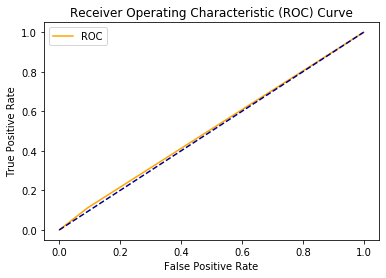

In [25]:
auc = roc_auc_score(Y_test,pred_labels)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(Y_test,pred_labels)
plot_roc_curve(fpr, tpr)